In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils.data as du
import utils.plots as pu
import utils.training as tu
import utils.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.utils.data as tdu
import mlflow
from tqdm import tqdm

/home/phoebus/MPRINCE/anaconda3/envs/soc_xrd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
scan_dataset = du.PosDataDatset('../../Data/robo_steer/raw/', 200)
train_size = int(0.8 * len(scan_dataset))
test_size = len(scan_dataset) - train_size
train_dataset, test_dataset = tdu.random_split(scan_dataset, [train_size, test_size], torch.Generator().manual_seed(42))

Discarded 4 invalid scans!


In [4]:
batch_size = 32
train_loader = tdu.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = tdu.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
use_cnn = False
if use_cnn:
    model = models.ConvNet(1)
else:
    hidden_size = 256
    num_layers = 2
    model = models.MLP(200, hidden_size, 1, num_layers)

In [6]:
mlflow.set_experiment('Manual')
mlflow.start_run()
mlflow_step = 0

In [7]:
lr = 0.00075
mlflow.log_param('lr', lr)
mlflow.log_param('is_cnn', 0)
optimizer = optim.AdamW(model.parameters(), lr=lr)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
num_epochs = 150

In [8]:
trainer = tu.Trainer(
    train_loader,
    test_loader,
    model, 
    optimizer,
    criterion
)

In [9]:
for epoch in tqdm(range(num_epochs)):
    trainer.train(1)

100%|██████████| 150/150 [01:47<00:00,  1.40it/s]


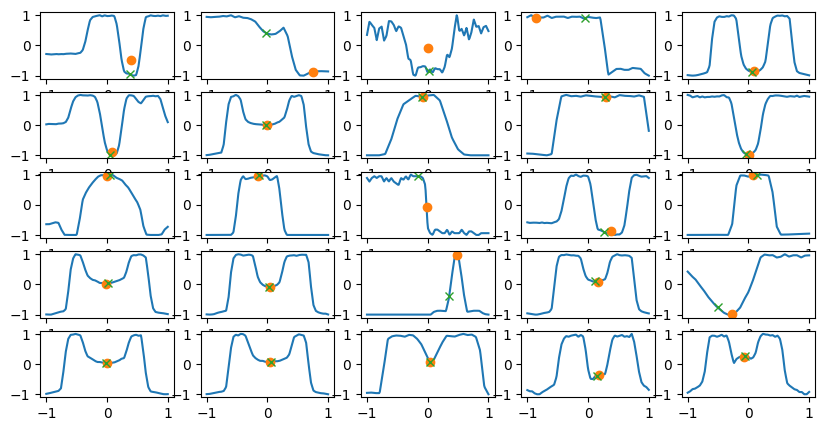

In [10]:
fig = pu.graph_sample(model, scan_dataset, test_dataset)

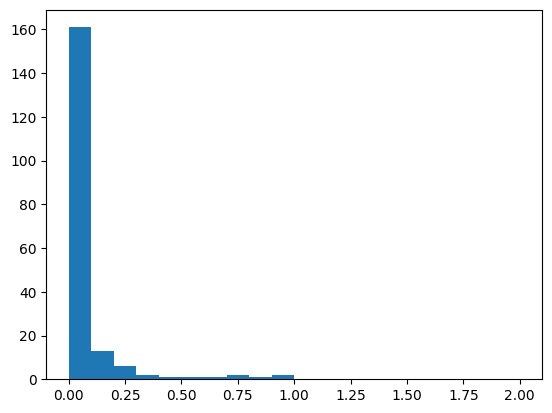

In [11]:
fig, hist_info = pu.plot_diff_hist(model, scan_dataset, test_dataset)

In [12]:
pu.print_hist_info(hist_info)

Total Range: 0.00-2.00
Err Range 0.00-0.10: 161 84.74%
Err Range 0.10-0.20: 13 6.84%
Err Range 0.20-0.30: 6 3.16%
Err Range 0.30-0.40: 2 1.05%
Err Range 0.40-0.50: 1 0.53%
Err Range 0.50-0.60: 1 0.53%
Err Range 0.60-0.70: 1 0.53%
Err Range 0.70-0.80: 2 1.05%
Err Range 0.80-0.90: 1 0.53%
Err Range 0.90-1.00: 2 1.05%


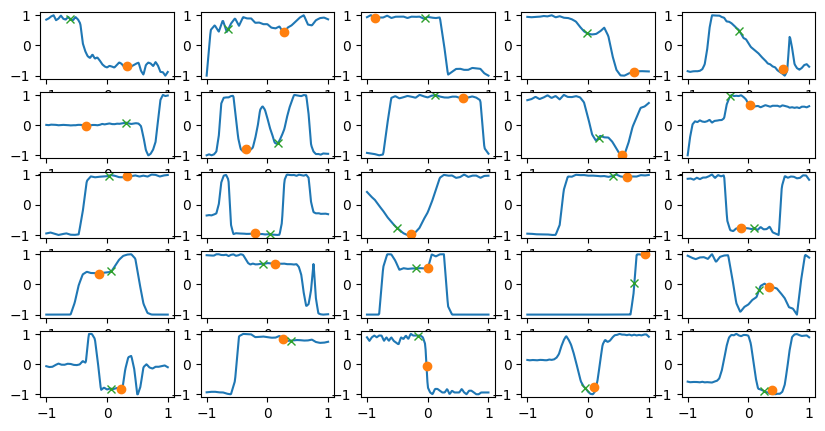

In [13]:
fig = pu.graph_ers(model, scan_dataset, test_dataset)

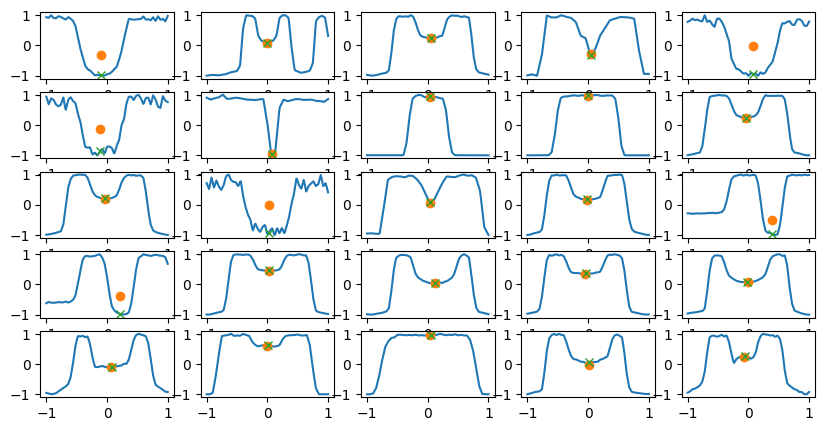

In [14]:
fig = pu.graph_ers(model, scan_dataset, test_dataset, False)

In [15]:
if use_cnn:
    torch.save(model.state_dict(), f'models_prod/cnn.ckpt')
    mlflow.log_artifact(f'models/cnn.ckpt')
else:
    torch.save(model.state_dict(), f'models_prod/mlp_{hidden_size}_{num_layers}.ckpt')
    mlflow.log_artifact(f'models/mlp_{hidden_size}_{num_layers}.ckpt')